In [1]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 15.5 MB/s eta 0:00:00


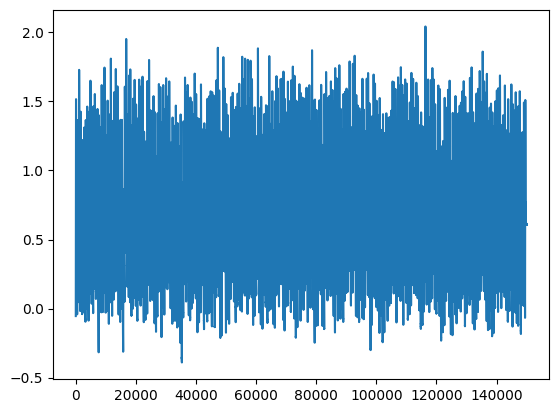

In [2]:
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import find_peaks
from scipy import signal
from scipy.integrate import trapz
from scipy.interpolate import interp1d
import seaborn as sns
from matplotlib.patches import Ellipse

ppg_simulated=nk.ppg_simulate(duration=300, sampling_rate=500, heart_rate=60)
plt.plot(ppg_simulated)
plt.show()

## Time Domain analysis

In [3]:
def timedomain(rr):
    results = {}

    hr = 60000/rr

    results['Mean RR (ms)'] = np.mean(rr)
    results['STD RR/SDNN (ms)'] = np.std(rr)
    results['Mean HR (Kubios\' style) (beats/min)'] = 60000/np.mean(rr)
    results['Mean HR (beats/min)'] = np.mean(hr)
    results['STD HR (beats/min)'] = np.std(hr)
    results['Min HR (beats/min)'] = np.min(hr)
    results['Max HR (beats/min)'] = np.max(hr)
    results['RMSSD (ms)'] = np.sqrt(np.mean(np.square(np.diff(rr))))
    results['NNxx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
    results['pNNxx (%)'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    return results

## Frequency Domain analysis

In [4]:
def frequency_domain(rri, fs=4):
    # Estimate the spectral density using Welch's method
    fxx, pxx = signal.welch(x=rr_interpolated, fs=fs)

    '''
    Segement found frequencies in the bands
     - Very Low Frequency (VLF): 0-0.04Hz
     - Low Frequency (LF): 0.04-0.15Hz
     - High Frequency (HF): 0.15-0.4Hz
    '''
    cond_vlf = (fxx >= 0) & (fxx < 0.04)
    cond_lf = (fxx >= 0.04) & (fxx < 0.15)
    cond_hf = (fxx >= 0.15) & (fxx < 0.4)

    # calculate power in each band by integrating the spectral density
    vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
    lf = trapz(pxx[cond_lf], fxx[cond_lf])
    hf = trapz(pxx[cond_hf], fxx[cond_hf])

    # sum these up to get total power
    total_power = vlf + lf + hf

    # find which frequency has the most power in each band
    peak_vlf = fxx[cond_vlf][np.argmax(pxx[cond_vlf])]
    peak_lf = fxx[cond_lf][np.argmax(pxx[cond_lf])]
    peak_hf = fxx[cond_hf][np.argmax(pxx[cond_hf])]

    # fraction of lf and hf
    lf_nu = 100 * lf / (lf + hf)
    hf_nu = 100 * hf / (lf + hf)

    results = {}
    results['Power VLF (ms2)'] = vlf
    results['Power LF (ms2)'] = lf
    results['Power HF (ms2)'] = hf
    results['Power Total (ms2)'] = total_power

    results['LF/HF'] = (lf/hf)
    results['Peak VLF (Hz)'] = peak_vlf
    results['Peak LF (Hz)'] = peak_lf
    results['Peak HF (Hz)'] = peak_hf

    results['Fraction LF (nu)'] = lf_nu
    results['Fraction HF (nu)'] = hf_nu
    return results, fxx, pxx

## Poincare analysis (non-linear)

In [5]:
def plot_poincare(rr):
    rr_n = rr[:-1]
    rr_n1 = rr[1:]

    sd1 = np.sqrt(0.5) * np.std(rr_n1 - rr_n)
    sd2 = np.sqrt(0.5) * np.std(rr_n1 + rr_n)

    m = np.mean(rr)
    min_rr = np.min(rr)
    max_rr = np.max(rr)

    plt.figure(figsize=(10, 10))
    plt.title("Poincare plot")

    sns.scatterplot(x=rr_n, y=rr_n1, color="#51A6D8")

    plt.xlabel(r'$RR_n (ms)$')
    plt.ylabel(r'$RR_{n+1} (ms)$')

    e1 = Ellipse((m, m), 2*sd1, 2*sd2, angle=-45, linewidth=1.2, fill=False, color="k")
    plt.gca().add_patch(e1)

    plt.arrow(m, m, (max_rr-min_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)
    plt.arrow(m, m, (min_rr-max_rr)*0.4, (max_rr-min_rr)*0.4, color="k", linewidth=0.8, head_width=5, head_length=5)

    plt.arrow(m, m, sd2 * np.sqrt(0.5), sd2 * np.sqrt(0.5), color="green", linewidth=5)
    plt.arrow(m, m, -sd1 * np.sqrt(0.5), sd1 * np.sqrt(0.5), color="red", linewidth=5)

    plt.text(max_rr, max_rr, "SD2", fontsize=20, color="green")
    plt.text(m-(max_rr-min_rr)*0.4-20, max_rr, "SD1", fontsize=20, color="red")

    return sd1, sd2

In [6]:
ppg_and_ecg=nk.data(dataset="bio_resting_5min_100hz")

### Plot the first 5 seconds of the data

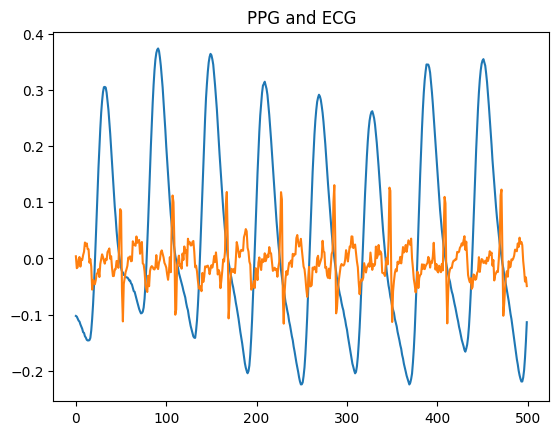

In [7]:
plt.plot(ppg_and_ecg['PPG'][0:500])
plt.plot(ppg_and_ecg['ECG'][0:500])
plt.title("PPG and ECG", color = "black")
plt.tick_params(axis="both", colors = "black")

In [8]:
diff_sig_2=np.diff(ppg_and_ecg['PPG'])

In [9]:
# HR will probably not go below 30 bpm : distance=500*(30/60))
# prominence found experimentally
peaks_2, _ = find_peaks(diff_sig_2, distance=100*(30/60), prominence=0.01)

### First 10 seconds of PPG measurements

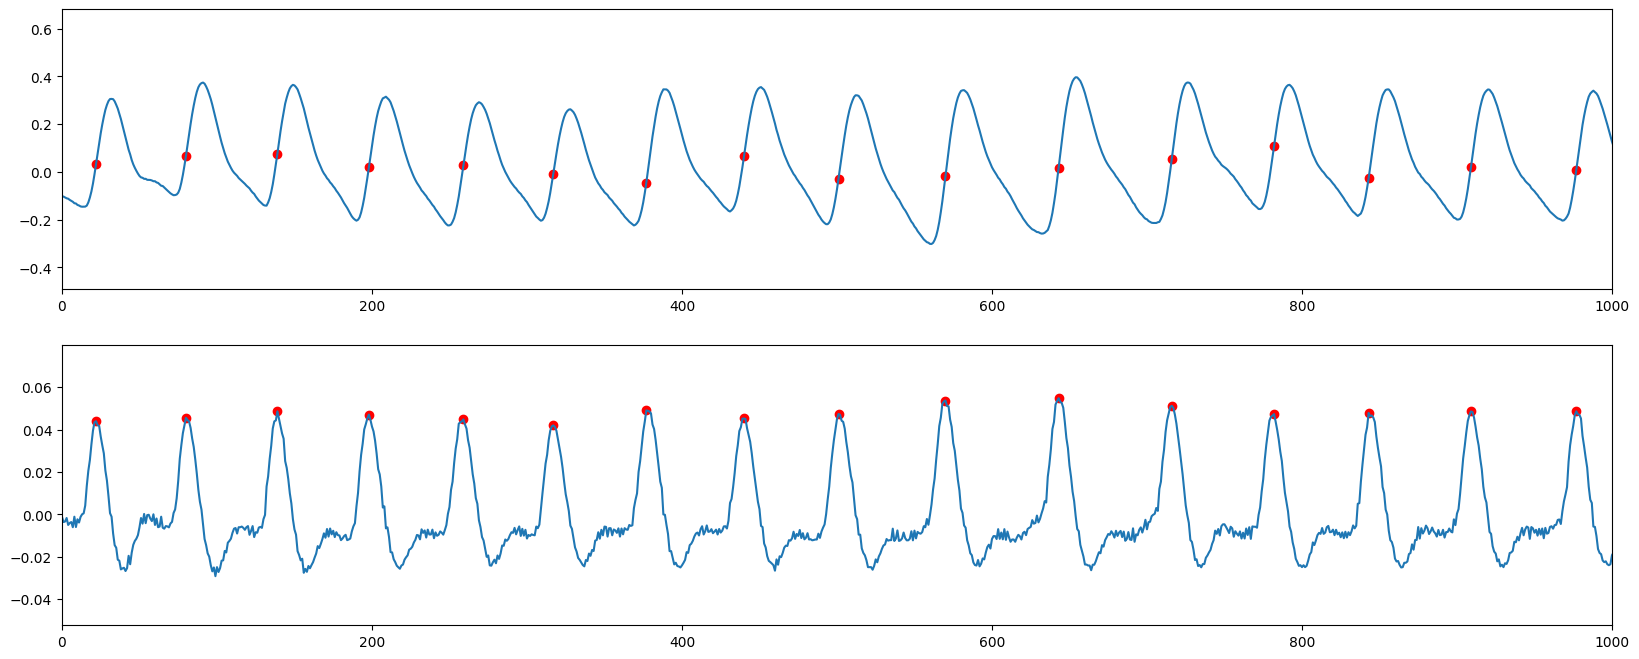

In [10]:
plt.figure(figsize=(20,8))
plt.subplot(2,1,1)
plt.plot(ppg_and_ecg['PPG'])
plt.scatter(peaks_2, ppg_and_ecg['PPG'][peaks_2], color="red")
plt.gca().set_xlim(0, 1000)
plt.subplot(2,1,2)
plt.plot(diff_sig_2)
plt.scatter(peaks_2, diff_sig_2[peaks_2], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()


In [11]:
rr_2 = np.diff(peaks_2)
corr_rr_2 = rr_2*10

In [12]:
timedomain(corr_rr_2)

{'Mean RR (ms)': 694.6171693735499,
 'STD RR/SDNN (ms)': 51.03821944801512,
 "Mean HR (Kubios' style) (beats/min)": 86.3785155989044,
 'Mean HR (beats/min)': 86.84239408606393,
 'STD HR (beats/min)': 6.354812992315708,
 'Min HR (beats/min)': 68.18181818181819,
 'Max HR (beats/min)': 109.0909090909091,
 'RMSSD (ms)': 41.07848415490908,
 'NNxx': 67,
 'pNNxx (%)': 15.54524361948956}

## To be able to do frequency analysis we have to interpolate the RR-interval curve (PPG)

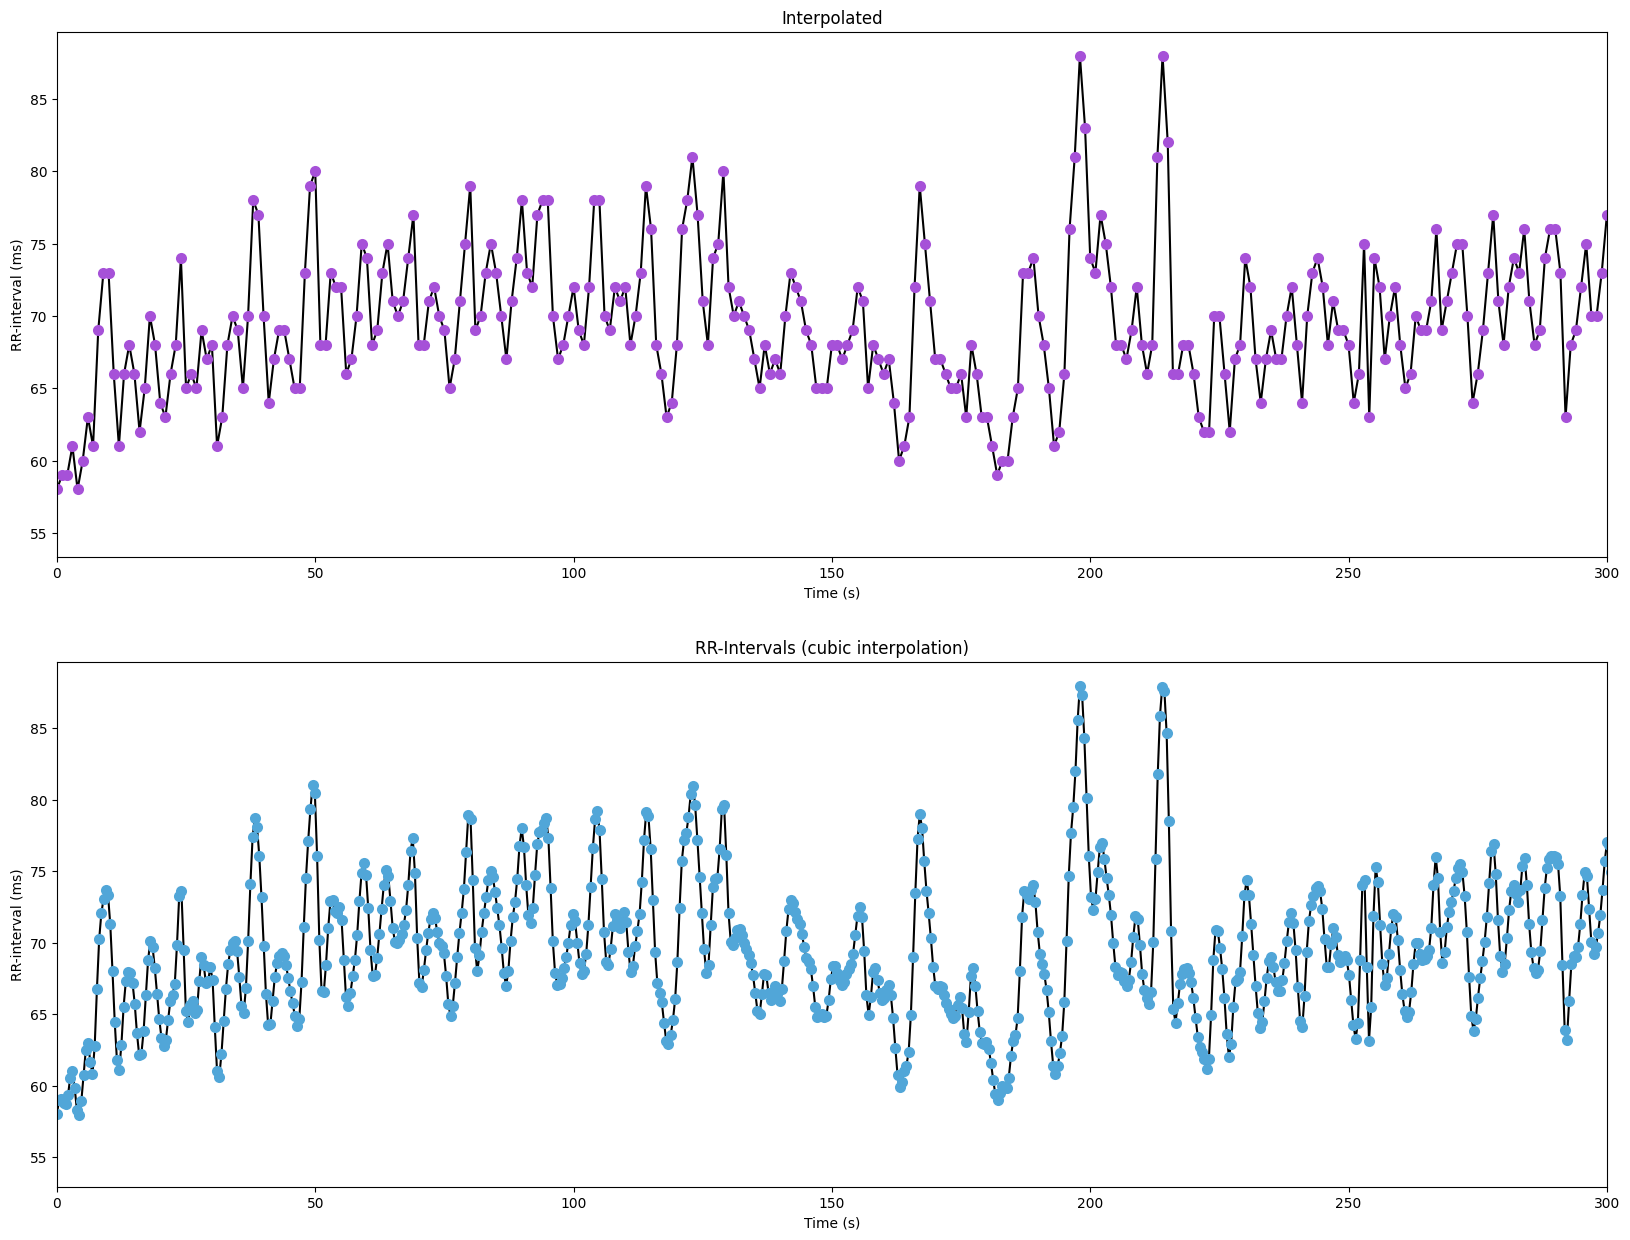

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d # import the interpolation function

# Assuming rr_2 is defined and available from previous code execution

# If x_2 represents a time axis, you likely need to create it.
# Here, we create x_2 using np.arange based on the length of rr_2
x_2 = np.arange(len(rr_2))

# Assuming rr_interpolated and xx_2 are meant for interpolation:
# Create xx_2 (interpolated time points) using np.linspace
# and replace xx_2 in the plot with this new variable
num_interpolation_points = 1000  # Adjust as needed
xx_2 = np.linspace(x_2.min(), x_2.max(), num_interpolation_points)

# Perform cubic interpolation
f = interp1d(x_2, rr_2, kind='cubic') # create the interpolation function
rr_interpolated = f(xx_2) # interpolate rr_2 onto xx_2


plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
# Now plot using the created x_2
plt.plot(x_2, rr_2, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 300)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
# Changed rr_interpolated_2 to rr_interpolated
# Replace xx_2 in the plot with the created xx_2
plt.plot(xx_2, rr_interpolated, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 300)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

In [18]:
print("Frequency domain metrics:")
results_2, fxx_2, pxx_2 = frequency_domain(rr_interpolated)

for k, v in results_2.items():
    print("- %s: %.2f" % (k, v))

Frequency domain metrics:
- Power VLF (ms2): 3.09
- Power LF (ms2): 6.26
- Power HF (ms2): 9.58
- Power Total (ms2): 18.93
- LF/HF: 0.65
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.11
- Peak HF (Hz): 0.34
- Fraction LF (nu): 39.55
- Fraction HF (nu): 60.45


<ipython-input-4-dd53a1e1b3d2>:16: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
<ipython-input-4-dd53a1e1b3d2>:17: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  lf = trapz(pxx[cond_lf], fxx[cond_lf])
<ipython-input-4-dd53a1e1b3d2>:18: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  hf = trapz(pxx[cond_hf], fxx[cond_hf])


## Welch periodogram (PPG)

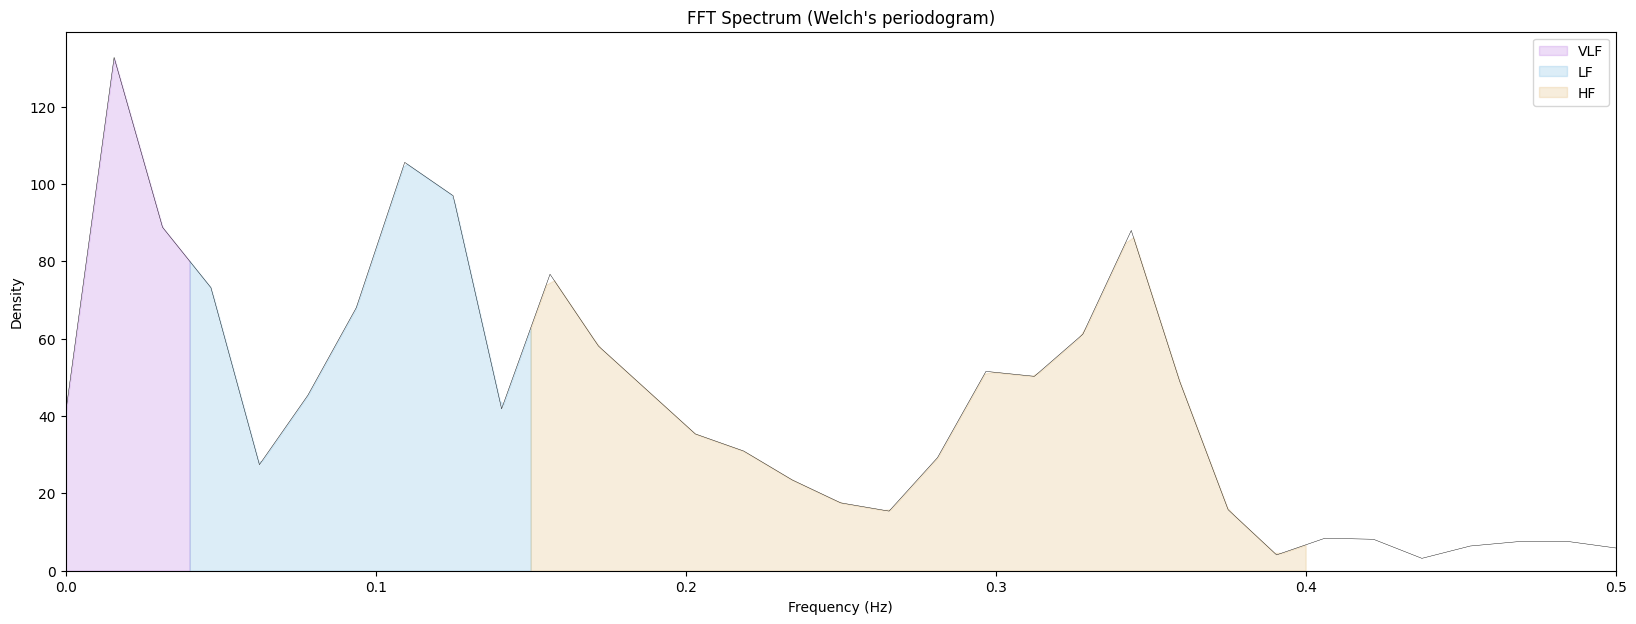

In [19]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_2, pxx_2, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_2, pxx_2)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

## Poincare diagram (PPG)

SD1: 2.905 ms
SD2: 6.592 ms


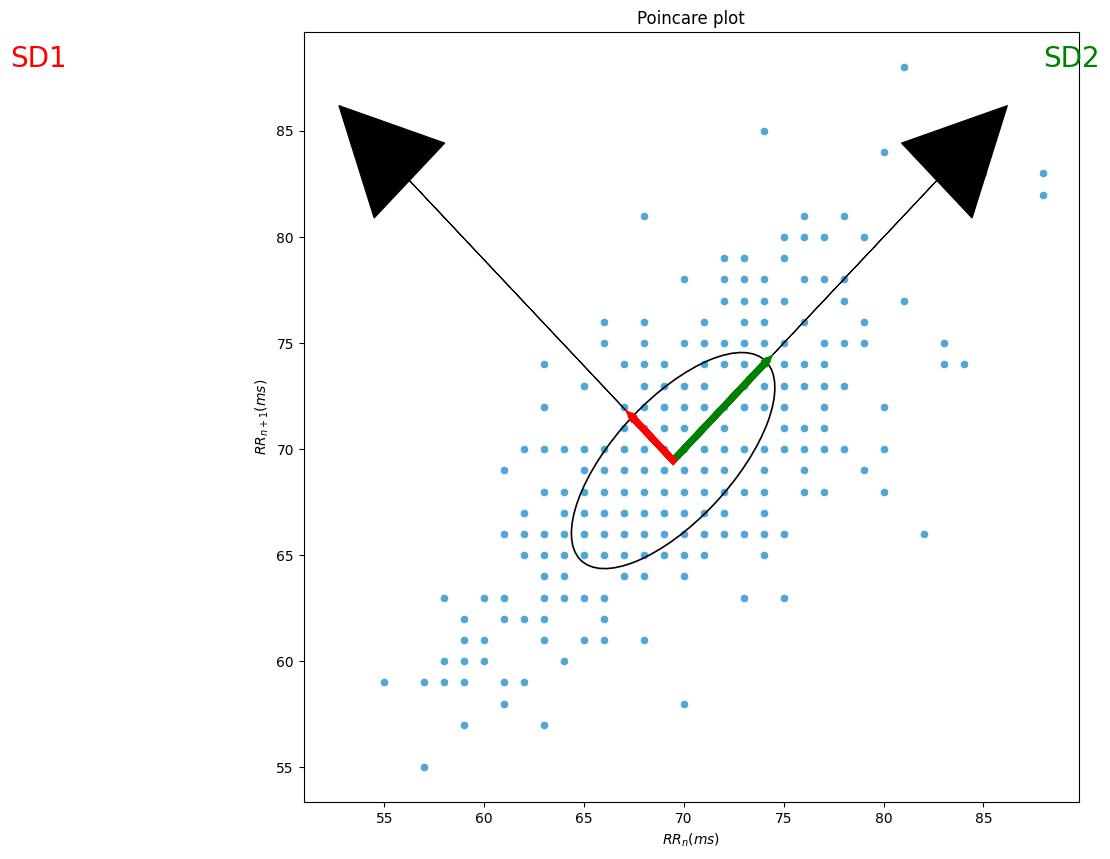

In [20]:
import seaborn as sns
from matplotlib.patches import Ellipse
sd1_2, sd2_2 = plot_poincare(rr_2)
print("SD1: %.3f ms" % sd1_2)
print("SD2: %.3f ms" % sd2_2)

# Analysis ECG signal

In [21]:
ecg_signals, info  = nk.ecg_process(ppg_and_ecg["ECG"], sampling_rate=100)

### Plot first 10 seconds of ECG signal

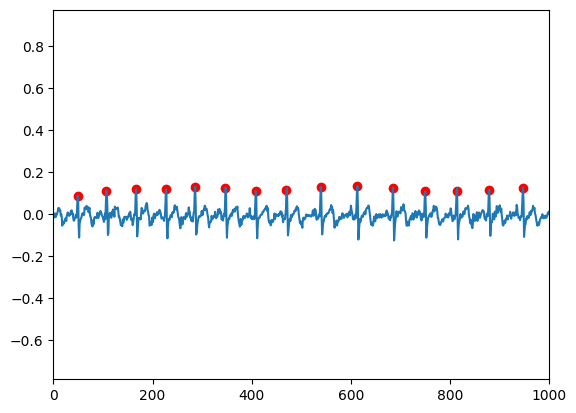

In [22]:
plt.plot(ppg_and_ecg["ECG"])
plt.scatter(info['ECG_R_Peaks'], ppg_and_ecg["ECG"][info['ECG_R_Peaks']], color="red")
plt.gca().set_xlim(0, 1000)
plt.show()

In [23]:
rr_ecg = np.diff(info['ECG_R_Peaks'])
corr_rr_ecg = rr_ecg*10

## Timedomain analysis of ECG

In [24]:
timedomain(corr_rr_ecg)

{'Mean RR (ms)': 694.7563805104409,
 'STD RR/SDNN (ms)': 48.97912382493174,
 "Mean HR (Kubios' style) (beats/min)": 86.36120758749665,
 'Mean HR (beats/min)': 86.7938136813782,
 'STD HR (beats/min)': 6.183591575643686,
 'Min HR (beats/min)': 69.76744186046511,
 'Max HR (beats/min)': 115.38461538461539,
 'RMSSD (ms)': 38.83776632381496,
 'NNxx': 57,
 'pNNxx (%)': 13.22505800464037}

## Interpolated ECG signal

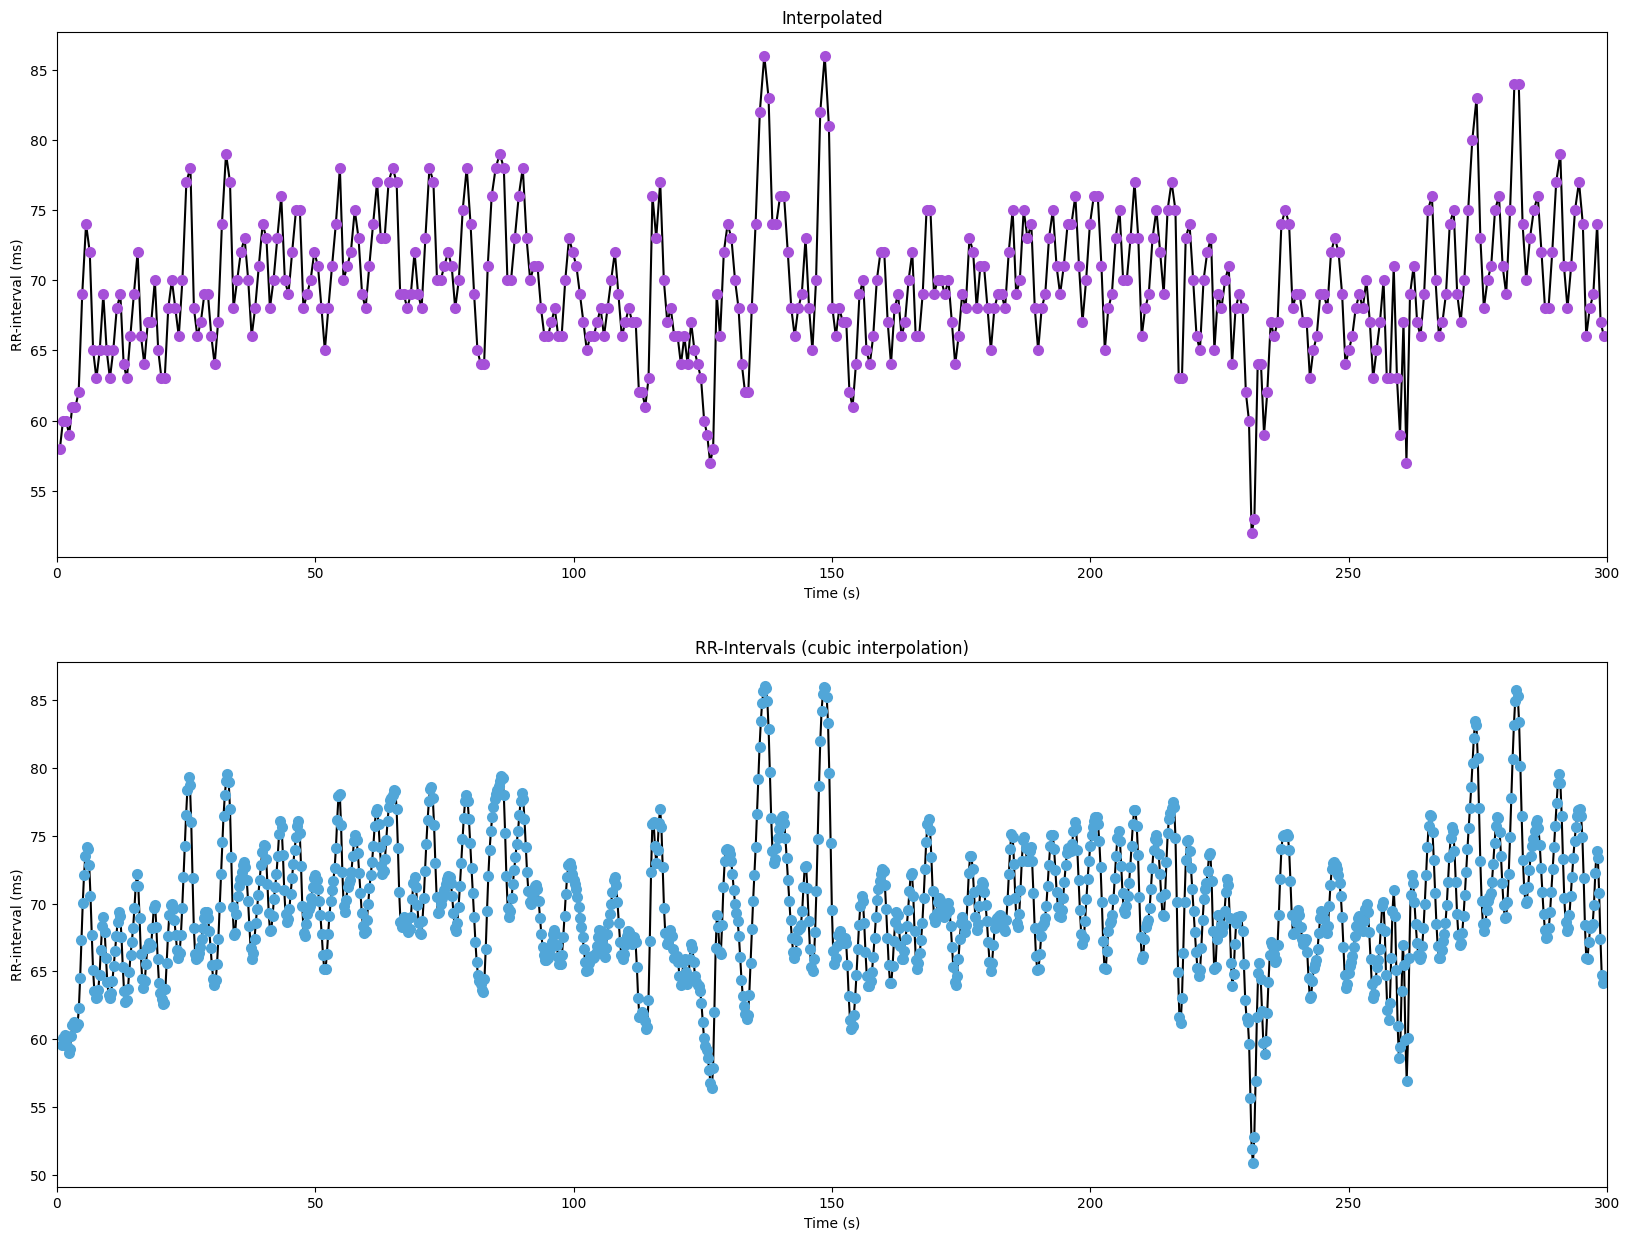

In [25]:
x_ecg = np.cumsum(rr_ecg)/ 100.0
f_ecg = interp1d(x_ecg, rr_ecg, kind='cubic',fill_value="extrapolate")

# sample rate for interpolation
fs = 4.0
steps = 1 / fs

# now we can sample from interpolation function
xx_ecg = np.arange(1, np.max(x_ecg), steps)
xx_ecg.shape

rr_interpolated_ecg = f_ecg(xx_ecg)

plt.figure(figsize=(20, 15))

plt.subplot(211)
plt.title("RR intervals")
plt.plot(x_ecg, rr_ecg, color="k", markerfacecolor="#A651D8", markeredgewidth=0, marker="o", markersize=8)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.title("Interpolated")
plt.gca().set_xlim(0, 300)

plt.subplot(212)
plt.title("RR-Intervals (cubic interpolation)")
plt.plot(xx_ecg, rr_interpolated_ecg, color="k", markerfacecolor="#51A6D8", markeredgewidth=0, marker="o", markersize=8)
plt.gca().set_xlim(0, 300)
plt.xlabel("Time (s)")
plt.ylabel("RR-interval (ms)")
plt.show()

## Frequenzy domain analysis off ECG signal

In [26]:
print("Frequency domain metrics:")
results_ecg, fxx_ecg, pxx_ecg = frequency_domain(rr_interpolated_ecg)

for k_e, v_e in results_ecg.items():
    print("- %s: %.2f" % (k_e, v_e))

Frequency domain metrics:
- Power VLF (ms2): 3.09
- Power LF (ms2): 6.26
- Power HF (ms2): 9.58
- Power Total (ms2): 18.93
- LF/HF: 0.65
- Peak VLF (Hz): 0.02
- Peak LF (Hz): 0.11
- Peak HF (Hz): 0.34
- Fraction LF (nu): 39.55
- Fraction HF (nu): 60.45


<ipython-input-4-dd53a1e1b3d2>:16: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  vlf = trapz(pxx[cond_vlf], fxx[cond_vlf])
<ipython-input-4-dd53a1e1b3d2>:17: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  lf = trapz(pxx[cond_lf], fxx[cond_lf])
<ipython-input-4-dd53a1e1b3d2>:18: DeprecationWarning: 'scipy.integrate.trapz' is deprecated in favour of 'scipy.integrate.trapezoid' and will be removed in SciPy 1.14.0
  hf = trapz(pxx[cond_hf], fxx[cond_hf])


# Welch diagram for ECG signal

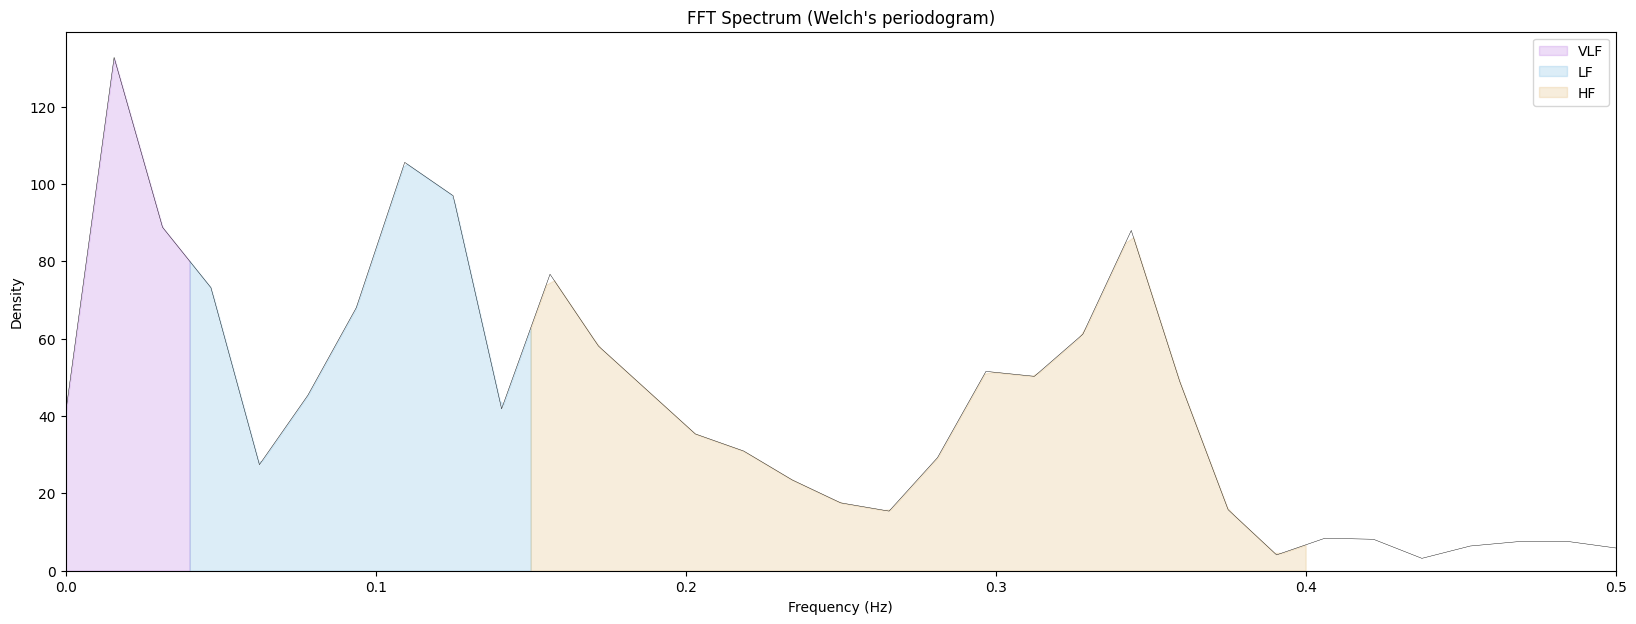

In [27]:
plt.figure(figsize=(20, 7))
plt.plot(fxx_ecg, pxx_ecg, color="k", linewidth=0.3)
plt.title("FFT Spectrum (Welch's periodogram)")

# create interpolation function for plotting frequency bands
psd_f = interp1d(fxx_ecg, pxx_ecg)

# setup frequency bands for plotting
x_vlf = np.linspace(0, 0.04, 100)
x_lf = np.linspace(0.04, 0.15, 100)
x_hf = np.linspace(0.15, 0.4, 100)

plt.gca().fill_between(x_vlf, psd_f(x_vlf), alpha=0.2, color="#A651D8", label="VLF")
plt.gca().fill_between(x_lf, psd_f(x_lf), alpha=0.2, color="#51A6D8", label="LF")
plt.gca().fill_between(x_hf, psd_f(x_hf), alpha=0.2, color="#D8A651", label="HF")

plt.gca().set_xlim(0, 0.5)
plt.gca().set_ylim(0)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Density")
plt.legend()
plt.show()

## Poincare analysis of ECG signal

SD1: 2.746 ms
SD2: 6.341 ms


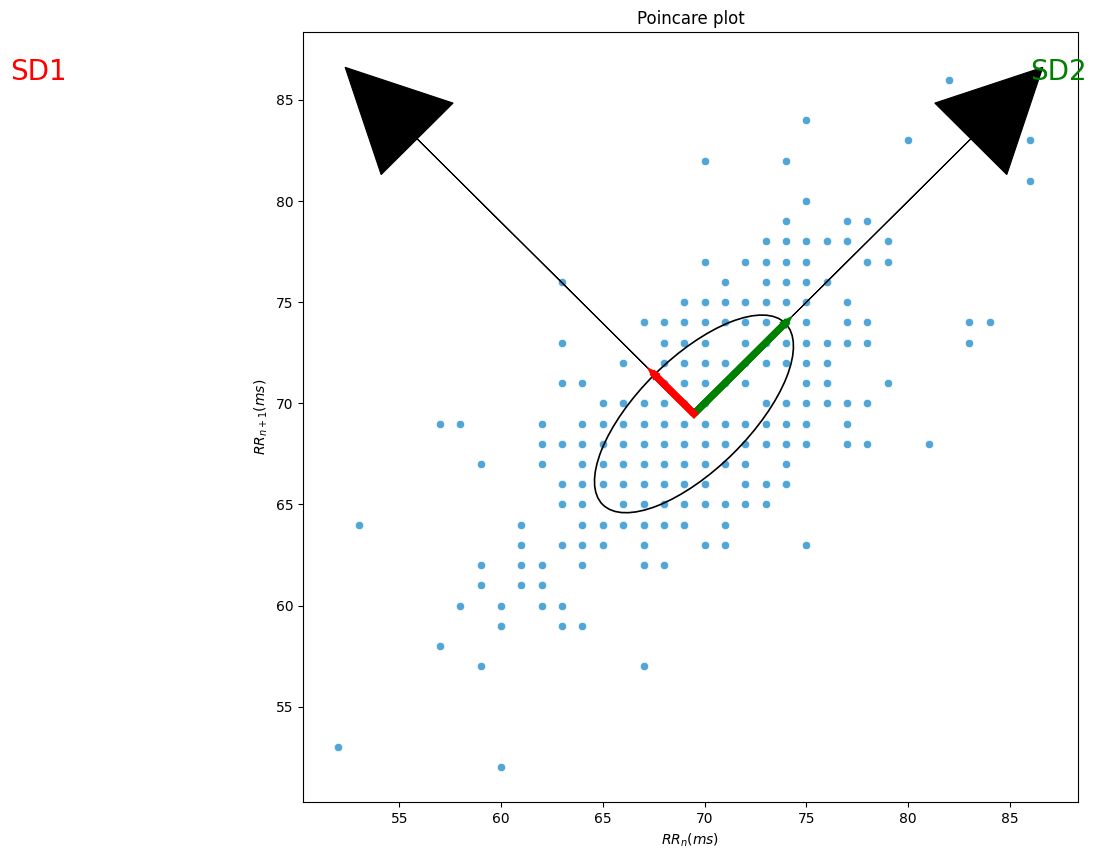

In [28]:
sd1_ecg, sd2_ecg = plot_poincare(rr_ecg)
print("SD1: %.3f ms" % sd1_ecg)
print("SD2: %.3f ms" % sd2_ecg)

## We wil use now use [PyHRV](https://pypi.org/project/pyhrv/) to analyze the data

In [29]:
!pip install hrv-analysis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.6/40.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 12.3 MB/s eta 0:00:00


In [30]:
!pip install pyhrv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.8/230.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 50.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.4/149.4 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.6/717.6 kB 42.1 MB/s eta 0:00:00
  Created wheel for spectrum: filename=spectrum-0.8.1-cp310-cp310-linux_x86_64.whl size=236597 sha256=c8312f455ff47e1a4fd676333a0f1e73229faea4254b224af42513e39fc335b6
  Stored in directory: /root/.cache/pip/wheels/e7/5a/09/ffc6afdf8a5a6f58e9851292108df32bb11374e11b8705cabd
Successfully built spectrum


In [31]:
from hrvanalysis import remove_outliers, remove_ectopic_beats, interpolate_nan_values

In [32]:
rr_intervals_list = info['ECG_R_Peaks']

In [33]:
import pyhrv.tools as tools

## Welch diagram - PPG signal

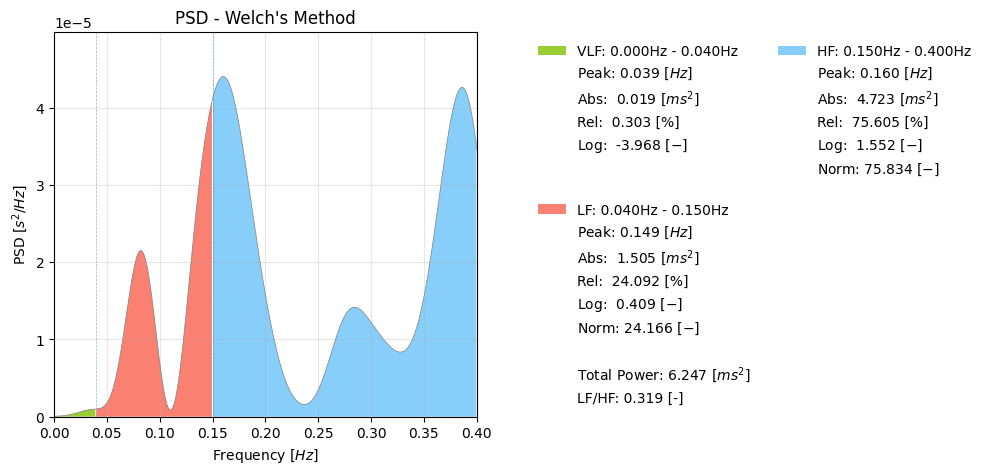

(0.0390625, 0.1494140625, 0.16015625)


In [34]:
import pyhrv.frequency_domain as fd
nni = tools.nn_intervals(rr_intervals_list)
result = fd.welch_psd(nni=nni)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

## Welch diagram - ECG signal

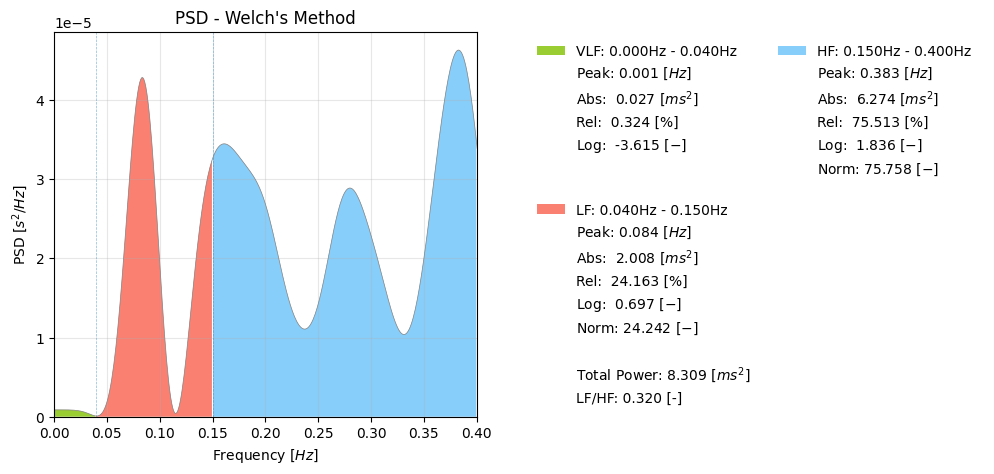

(0.0009765625, 0.083984375, 0.3828125)


In [35]:
nni_2 = tools.nn_intervals(peaks_2)
result = fd.welch_psd(nni=nni_2)
# Access peak frequencies using the key 'fft_peak'
print(result['fft_peak'])

# Non-linear analysis using PyHRV
### Poincare analysis PPG

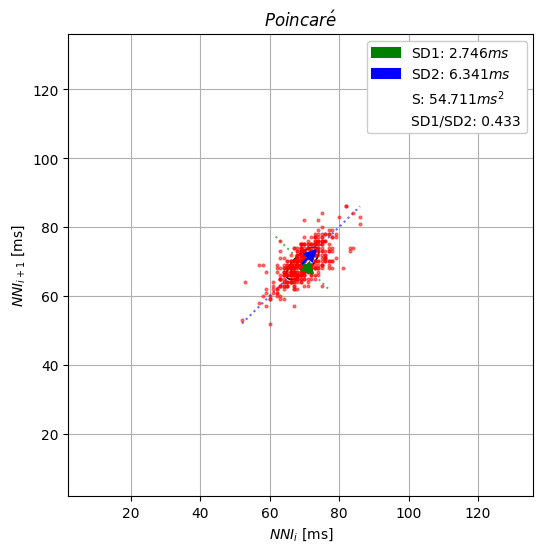

2.7462132835222093


In [36]:
import pyhrv.nonlinear as nl
result = nl.poincare(nni)
print(result['sd1'])

### Sample Entropy PPG

In [37]:
result = nl.sample_entropy(nni)
print(result['sampen'])

1.9786368425578704


### Poincare analysis ECG

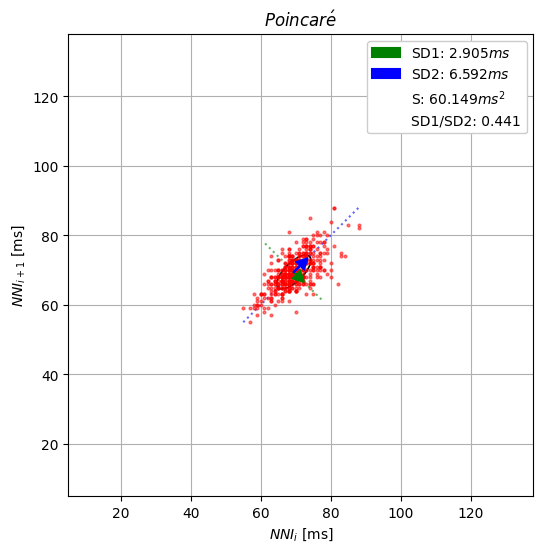

2.904657679624767


In [38]:
result = nl.poincare(nni_2)
print(result['sd1'])

In [39]:
result = nl.sample_entropy(nni_2)
print(result['sampen'])

1.388903285114691


In [43]:
# prompt: deploye code in cloud

!pip install neurokit2
!pip install hrv-analysis
!pip install pyhrv
# ... (rest of your existing code) ...